<a href="https://colab.research.google.com/github/FootlyIQ/ML_models/blob/main/Footly_xT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.stats import binned_statistic_2d

In [ ]:
df_stories = duckdb.sql(f"""
    SELECT * FROM '/content/drive/MyDrive/footly_data/stories.parquet'
    WHERE type = 'pass'
""").df()

df_stories.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(968435, 138)

In [ ]:
#Znebim se podaj, ki so koncale v avtu
df_stories_filtered = df_stories[df_stories['ball_out'] != True]
df_stories_filtered.shape

(968435, 138)

In [ ]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_move = df_stories_filtered.copy()
df_move["start_x"] *= 105 / 100
df_move["start_y"] *= 68 / 100
df_move["end_x"] *= 105 / 100
df_move["end_y"] *= 68 / 100

df_move.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,51.45,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,0
1,CF,False,28.35,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,1
2,RCB,False,59.85,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,3


In [ ]:
# Recalculate pass_length using scaled coordinates
df_move["pass_length"] = np.sqrt(
    (df_move["end_x"] - df_move["start_x"])**2 +
    (df_move["end_y"] - df_move["start_y"])**2
)

df_move.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,51.45,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,0
1,CF,False,28.35,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,1
2,RCB,False,59.85,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,3


In [ ]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [ ]:
import pyarrow
import fastparquet

In [ ]:
df_move.shape

(968435, 138)

In [ ]:
df_move["cross"].value_counts()

,count
cross,
False,934949
True,33486


In [ ]:
# List of columns to keep
columns_to_keep = [
    'id',
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'pass_length',
    'successful',
    'pass_high',
    'player_id',
    'team_id',
    'pass_recipient_id',
    'player_position',
    'season',
    'long_pass',
    'possession_id',
    'minute',
    'cross'
]

# Select only the desired columns
df_done = df_move[columns_to_keep]

# Display the first few rows to verify
df_done.head()

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute,cross
0,1296149340,51.45,34.00,28.35,29.92,23.457545,True,False,302292,1609,346158,AMF,2021,False,1296149340,0,False
1,1296151267,28.35,29.92,67.20,46.24,42.138639,False,True,346158,1609,-1,CF,2021,True,1296149340,0,False
2,1296149344,59.85,54.40,70.35,62.56,13.297955,True,False,370224,1609,302292,RCB,2021,False,1296149340,0,False
3,1296149345,70.35,62.56,71.40,55.08,7.553337,True,True,302292,1609,70389,AMF,2021,False,1296149340,0,False
4,1296149347,66.15,42.84,68.25,14.96,27.958977,True,False,120339,1609,49876,RDMF,2021,False,1296149346,0,False


In [ ]:
# Save the reduced DataFrame as Parquet
df_done.to_parquet('/content/drive/MyDrive/footly_data/passes_crosses_Done.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


In [ ]:
# List of columns to keep
columns_to_keep_2 = [
    'id',
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'team_id'
]

# Select only the desired columns
df_done_2 = df_move[columns_to_keep_2]

# Display the first few rows to verify
df_done_2.head(2)

,id,start_x,start_y,end_x,end_y,team_id
0,1296149340,51.45,34.00,28.35,29.92,1609
1,1296151267,28.35,29.92,67.20,46.24,1609


In [ ]:
df_done_2.shape

(968435, 5)

In [ ]:
# Save the reduced DataFrame as Parquet
df_done_2.to_parquet('/content/drive/MyDrive/footly_data/moving_small.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


In [ ]:
# Randomly sample 50% of the DataFrame
df_smaller = df_move.sample(frac=0.5, random_state=123)

# Optionally, reset the index if needed
df_smaller.reset_index(drop=True, inplace=True)

print(f"Original size: {len(df_move)}, Reduced size: {len(df_smaller)}")

Original size: 968435, Reduced size: 484218


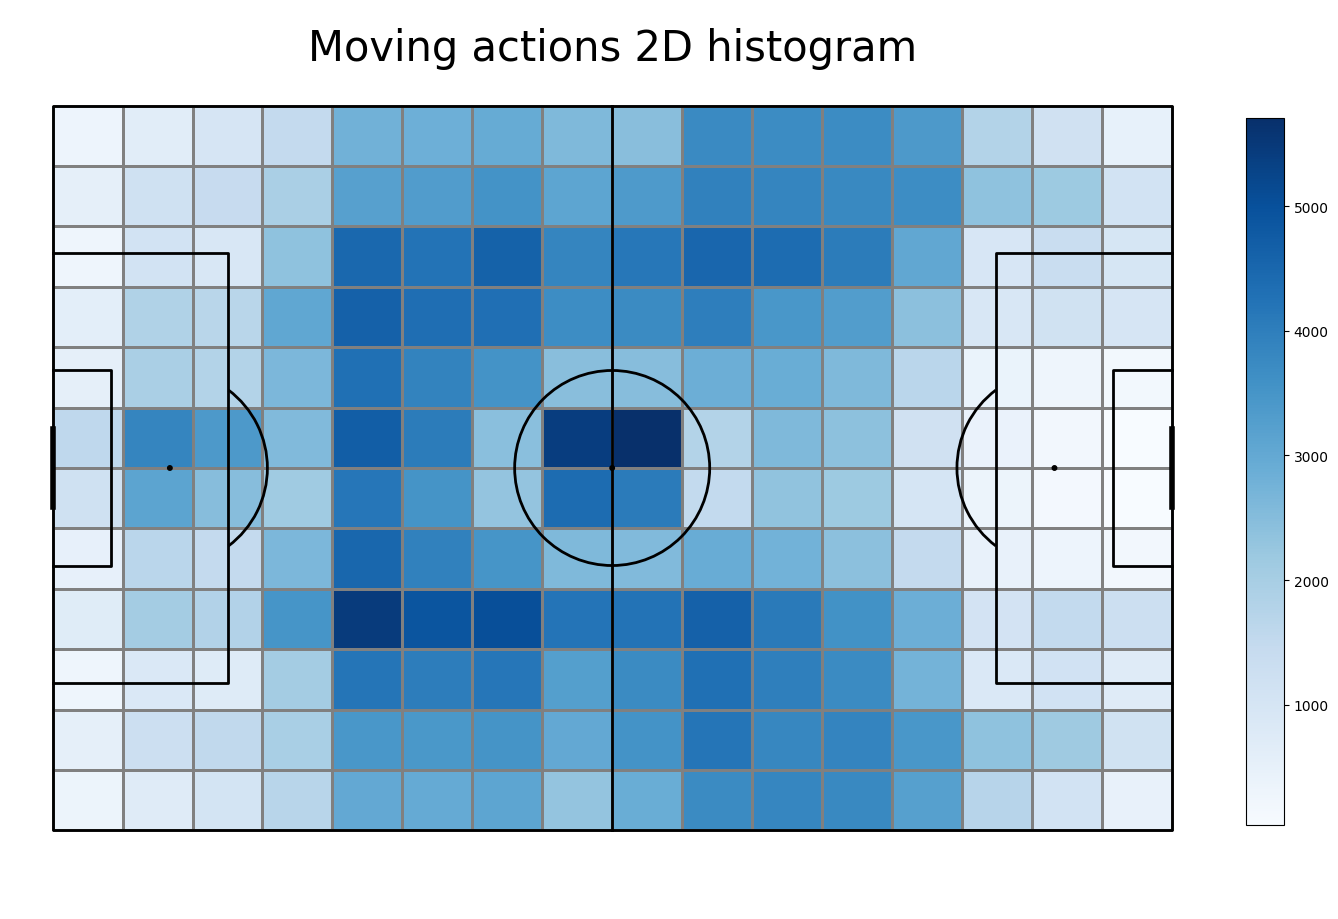

In [ ]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(df_smaller.start_x, df_smaller.start_y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

## Shots

In [ ]:
df_shots = duckdb.sql(f"""
    SELECT * FROM '/content/drive/MyDrive/footly_data/stories.parquet'
    WHERE type = 'shot'
""").df()

df_shots.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(26460, 138)

In [ ]:
df_copy = df_shots.copy()
df_copy["start_x"] *= 105 / 100
df_copy["start_y"] *= 68 / 100
df_copy["end_x"] *= 105 / 100
df_copy["end_y"] *= 68 / 100

In [ ]:
columns_to_keep_3 = [
    'id',
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'team_id'
]

# Select only the desired columns
df_done_3 = df_copy[columns_to_keep_3]

# Display the first few rows to verify
df_done_3.head(2)

,id,start_x,start_y,end_x,end_y,team_id
0,1296149438,98.7,28.56,-1.05,-0.68,1609
1,1296149466,88.2,25.84,-1.05,-0.68,1609


In [ ]:
# Save the reduced DataFrame as Parquet
df_done_3.to_parquet('/content/drive/MyDrive/footly_data/shots_small.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


In [ ]:
df_done_3.shape

(26460, 6)